In [3]:
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator



In [4]:
def plot_steps(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        iteration = data.iloc[runIdx]["iteration"]
        clusters = data.iloc[runIdx]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters))
        print("iteration: %s, clusters: %s" % (iteration, len(clusters)))
        for cIdx in range(0, len(clusters)):
            rgba_color = cm.gnuplot(norm(cIdx))
            pointsX = [point[0] for point in clusters[cIdx]["points"]]
            pointsY = [point[1] for point in clusters[cIdx]["points"]]
            ax.scatter(pointsX, pointsY, color=rgba_color)
            ax.scatter(clusters[cIdx]["centroid"][0], clusters[cIdx]["centroid"][1], color=rgba_color, marker="+")

        plt.show()

In [5]:
def plot(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        clusters_step1 = data.iloc[runIdx]["steps"][0]["clusters"]
        clusters_step2 = data.iloc[runIdx]["steps"][1]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters_step1))
        for cIdx in range(0, len(clusters_step1)):
            rgba_color = cm.gnuplot(norm(cIdx))
            ax.plot(clusters_step1[cIdx]["syntheticCenter"], "--", color=rgba_color, label="cluster %s" % cIdx)
            ax.plot(clusters_step2[cIdx]["syntheticCenter"], color=rgba_color, label="cluster %s - rescheduled" % cIdx)
            print(clusters_step2[cIdx]["metric"])
        ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)

        ax.set(xlabel='Hours', ylabel='Power (kW)',title='')
        plt.show()

In [6]:
def plot_aggm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. agg m"], "--", color=rgba_color, label="s1. agg m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. agg m"], color=rgba_color, label="s2. agg m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_maxm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. max m"], "--", color=rgba_color, label="s1. max m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. max m"], color=rgba_color, label="s2. max m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Max. Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_peak(summary, file_name=None):
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. peak"], "--", color=rgba_color, label="s1. peak")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. peak"], color=rgba_color, label="s2. peak")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Peak power (kW)',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig

# PAR Aggregate

In [19]:
summaryBatch_global = pd.read_json("./files/scheduler_tests/scheduler_test/summaryBatch.json")
#summaryBatch_global = summaryBatch_global[["k","clusters","s1. agg m","s1. max m","s1. peak","s2. agg m","s2. max m","s2. peak","total m"]]
#batch_global = pd.read_json("./files/batch.json")

exp1_k = 6
exp1_sample_size_min = 0.5
exp1_sample_size_max = 1.0
exp1_nsteps = 2


def sample_size_range(sample_size_min, sample_size_max):
    return (x/10 for x in range(int(sample_size_min * 10), int((sample_size_max * 10) + 1)))

In [20]:
def crossfold_as_df(k, data):
    index_list = []
    step_list = []

    for i in range(0 , len(data)):
        register = data.iloc[i]

        crossfold = json_normalize(register["crossfold"])
        splits = crossfold["splits"].values[0]
        steps = data.iloc[i]["step"]
        for j in range(0, splits):
            step = json_normalize(steps[j])
            for ki in range(1, k+1):
                index_list.append((float("{0:.2f}".format(crossfold["sampleSize"].values[0])), j, ki))
                step_list.append(step.iloc[ki-1])


    json_normalize(data.iloc[0]["crossfold"])
    json_normalize(data.iloc[0]["step"][0])

    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "split", "k"])
    return pd.DataFrame(step_list, index=index)
exp1_treated = crossfold_as_df(exp1_k, summaryBatch_global)
exp1_treated

k  s1. peak  s1. agg m  s1. max m  s1. total m  \
sampleSize split k                                                   
0.5        0     1  1    723878   2.384306   2.384306     2.384306   
                 2  2    368207   1.006668   2.400033     2.384306   
                 3  3    313186   1.024620   2.447037     2.384306   
                 4  4    268308   1.056994   2.897014     2.384306   
                 5  5    243121   1.041882   2.997109     2.384306   
...                ..       ...        ...        ...          ...   
1.0        3     2  2    682770   1.017920   2.005380     1.965393   
                 3  3    421026   1.048988   2.113317     1.965393   
                 4  4    347085   1.045802   2.218112     1.965393   
                 5  5    381156   1.067043   2.512477     1.965393   
                 6  6    333175   1.071336   2.553569     1.965393   

                                clusters  s2. peak  s2. agg m  s2. max m  \
sampleSize split k                                                         
0.5        0     1                  [25]    674381   2.221273   2.221273   
                 2              [11, 14]    368207   1.081413   2.400033   
                 3           [10, 10, 5]    263689   1.093208   2.447037   
                 4          [9, 5, 5, 6]    206232   1.194448   2.897014   
                 5       [6, 6, 5, 5, 3]    181849   1.161603   2.890363   
...                                  ...       ...        ...        ...   
1.0        3     2              [24, 26]    655551   1.009627   1.857641   
                 3          [19, 15, 16]    411984   1.042249   1.943186   
                 4      [14, 13, 13, 10]    335881   1.061515   2.218112   
                 5   [14, 10, 11, 11, 4]    353937   1.164132   2.629791   
                 6  [13, 5, 8, 9, 10, 5]    333175   1.096710   2.448012   

                    s2. total m  
sampleSize split k               
0.5        0     1     2.221273  
                 2     2.221273  
                 3     2.221273  
                 4     2.221273  
                 5     2.221273  
...                         ...  
1.0        3     2     1.842278  
                 3     1.842278  
                 4     1.842278  
                 5     1.842278  
                 6     1.842278  

[144 rows x 10 columns]

In [21]:
k2 = 2
query = f"k == {k2} and sampleSize == {exp1_sampleSizeMin}"
exp1_treated.query(query)["s1. agg m"].mean()
exp1_treated.query(query)["s1. max m"].mean()
exp1_treated.query(query)["s1. peak"].std()

23609.548280303883

In [43]:
def get_statistics(k, nSteps, treated, sample_size_min, sample_size_max):
    index_list = []
    step_list = []

    for j in range(1, k+1):
        for ssize in sample_size_range(sample_size_min, sample_size_max):

            index_list.append((ssize, "mean", j))
            query = f"k == {j} and sampleSize == {ssize}"
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            data = {key: treated.query(query)[key].mean() for key in index}
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].mean(),
                    "s1. max m" : treated.query(query)["s1. max m"].mean(), 
                    "s1. peak" : treated.query(query)["s1. peak"].mean()/1000,
                   "s1. total m" : treated.query(query)["s1. total m"].mean()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            if (nSteps >= 2):
                data.update({"s2. agg m" : treated.query(query)["s2. agg m"].mean(),
                    "s2. max m" : treated.query(query)["s2. max m"].mean(), 
                    "s2. peak" : treated.query(query)["s2. peak"].mean()/1000,
                            "s2. total m" : treated.query(query)["s2. total m"].mean()})
                index = index + ["s2. agg m","s2. max m","s2. peak", "s2. total m"]

            s = pd.Series(data,index=index) 
            step_list.append(s)
            #print(f"sampleSize = {ssize}, k = {j}")

            index_list.append((ssize, "stdv", j))
            query = f"k == {j} and sampleSize == {ssize}"
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].std(),
                    "s1. max m" : treated.query(query)["s1. max m"].std(), 
                    "s1. peak" : treated.query(query)["s1. peak"].std(),
                   "s1. total m" : treated.query(query)["s1. total m"].std()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            if (nSteps >= 2):
                data.update({"s2. agg m" : treated.query(query)["s2. agg m"].std(),
                    "s2. max m" : treated.query(query)["s2. max m"].std(), 
                    "s2. peak" : treated.query(query)["s2. peak"].std(),
                            "s2. total m" : treated.query(query)["s2. total m"].std()})
                index = index + ["s2. agg m","s2. max m","s2. peak", "s2. total m"]

            s = pd.Series(data,index=index) 
            step_list.append(s)


    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "metric", "k"])
    return pd.DataFrame(step_list, index=index)
exp1_statistics = get_statistics(exp1_k,exp1_nsteps, exp1_treated, exp1_sample_size_min, exp1_sample_size_max)
exp1_statistics

s1. agg m  s1. max m      s1. peak  s1. total m  \
sampleSize metric k                                                    
0.5        mean   1   2.104190   2.104190    649.018500     2.104190   
           stdv   1   0.257739   0.257739  50471.676496     0.257739   
0.6        mean   1   2.091344   2.091344    771.555500     2.091344   
           stdv   1   0.281289   0.281289  63964.119528     0.281289   
0.7        mean   1   1.978243   1.978243    915.618000     1.978243   
...                        ...        ...           ...          ...   
0.8        stdv   6   0.041895   0.103525  39475.820257     0.131721   
0.9        mean   6   1.070674   2.697848    289.790000     2.007168   
           stdv   6   0.023030   0.063963  29294.028993     0.030823   
1.0        mean   6   1.083304   2.550948    345.448500     1.965393   
           stdv   6   0.026985   0.041788   9585.185044     0.000000   

                     s2. agg m  s2. max m      s2. peak  s2. total m  
sampleSize metric k                                                   
0.5        mean   1   1.964818   1.964818    606.338500     1.964818  
           stdv   1   0.227287   0.227287  45708.765305     0.227287  
0.6        mean   1   2.003190   2.003190    738.767000     2.003190  
           stdv   1   0.316298   0.316298  84742.226546     0.316298  
0.7        mean   1   1.841066   1.841066    852.241000     1.841066  
...                        ...        ...           ...          ...  
0.8        stdv   6   0.037556   0.103525  39475.820257     0.078943  
0.9        mean   6   1.115920   2.649546    287.085750     1.871403  
           stdv   6   0.007690   0.086697  30934.066522     0.028852  
1.0        mean   6   1.129761   2.491080    335.695500     1.842278  
           stdv   6   0.030879   0.058135  21771.203649     0.000000  

[72 rows x 8 columns]

In [44]:
def get_metrics(k, metric, metric_type, statistics, exp1_sample_size_min, exp1_sample_size_max):

    index_list = [sample_size_range(exp1_sample_size_min, exp1_sample_size_max)]
    cols = [x for x in range(1, k+1)]
    step_list = []

    for ssize in sample_size_range(exp1_sample_size_min, exp1_sample_size_max):
        query = f"sampleSize == {ssize} and metric == \"{metric_type}\" "
        dataAllK = statistics.query(query)[f"{metric}"]
        dictAllK = {}
        for j in range(1, k+1):
            d = dataAllK.reset_index().query(f"k == {j}")[f"{metric}"]
            dictAllK[f"{j}"] = d.values[0]
        s = pd.Series(dictAllK, name=f"{ssize}")
        step_list.append(s)

    return pd.DataFrame(step_list)
    
mname = "s1. max m"
mtype = "mean"
m = get_metrics(exp1_k, mname, mtype, exp1_statistics, exp1_sample_size_min, exp1_sample_size_max)

In [45]:
m

,1,2,3,4,5,6
0.5,2.104190,2.278238,2.608090,2.876451,3.094775,3.308023
0.6,2.091344,2.176770,2.410194,2.609558,2.909490,2.943635
0.7,1.978243,2.040866,2.252191,2.518633,2.715660,2.825923
0.8,1.948852,2.022714,2.269979,2.428494,2.584383,2.728471
0.9,2.007168,2.048752,2.182663,2.298194,2.519636,2.697848
1.0,1.965393,1.988692,2.091003,2.254134,2.344783,2.550948


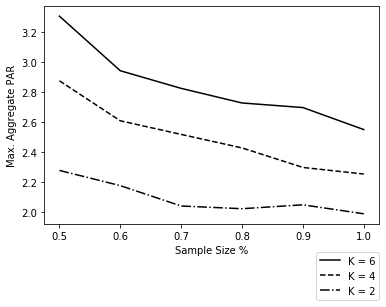

In [46]:
fig, ax = plt.subplots()

k2 = 6
sampleMaxMDataset = m2[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "-", label=f"K = {k2}", c="black")

k2 = 4
sampleMaxMDataset = m2[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "--", label=f"K = {k2}", c="black")

k2 = 2
sampleMaxMDataset = m2[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "-.", label=f"K = {k2}", c="black")

lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0.)
ax.set(xlabel='Sample Size %', ylabel='Max. Aggregate PAR',title='')
plt.show()
file_name = "peakpower_samplesize.pdf"
if file_name is not None:
    fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')


In [47]:
a = exp1_statistics.query("sampleSize == 1.0 and metric == \"mean\"").reset_index().drop(["sampleSize", "metric"], axis=1)

In [48]:
def show_summary(k, summary_treated):
    _list = {}
    for j in range(1, k+1):
        _list[j - 1] = str(summary_treated.query(f"sampleSize == 1.0 and k == {j}").sort_values(by=["s1. max m", "s1. agg m"]).iloc[0]["clusters"])
    _list
    b = pd.DataFrame.from_dict(_list, orient="index", columns=["clusters"])
    r = pd.concat([a,b], axis=1, sort=False)
    r = r[["k", "clusters", "s1. agg m", "s1. max m", "s1. peak", "s2. agg m", "s2. max m", "s2. peak"]]
    return r

show_summary(exp1_k, exp1_treated)

,k,clusters,s1. agg m,s1. max m,s1. peak,s2. agg m,s2. max m,s2. peak
0,1,[50],1.965393,1.965393,1224.68700,1.842278,1.842278,1147.97100
1,2,"[25, 25]",1.009222,1.988692,668.92800,1.034871,1.933632,642.94425
2,3,"[14, 19, 17]",1.029428,2.091003,450.64525,1.053632,2.042773,429.20575
3,4,"[13, 13, 14, 10]",1.043469,2.254134,394.59050,1.087688,2.254134,366.95675
4,5,"[14, 11, 10, 9, 6]",1.061850,2.344783,363.20475,1.115961,2.370888,352.64000
5,6,"[9, 11, 8, 7, 8, 7]",1.083304,2.550948,345.44850,1.129761,2.491080,335.69550


In [51]:
get_metrics(exp1_k, "s1. agg m", "mean", exp1_statistics, exp1_sample_size_min, exp1_sample_size_max).iloc[-1]

1    1.965393
2    1.009222
3    1.029428
4    1.043469
5    1.061850
6    1.083304
Name: 1.0, dtype: float64

In [52]:
with open('summaryBatch.tex','w') as tf:
    tf.write(r.to_latex())

NameError: name 'r' is not defined